In [1]:
import json

import gensim
from gensim.models import Word2Vec

import pandas as pd

import nltk
from nltk.stem import WordNetLemmatizer

import re

from sklearn.decomposition import PCA, KernelPCA

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import math

c:\users\yasht\fakenews\venv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')


# Loading reviews

In [3]:
# Read reviews
# Data obtained from https://jmcauley.ucsd.edu/data/amazon/
with open('Musical_Instruments_5.json') as data_file:
    def load_review(line):
        review = json.loads(line)
        return [float(review['overall']), review['reviewText']]
    reviews = list(map(load_review, data_file))

In [4]:
reviews[0]

[5.0,
 "Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,"]

In [5]:
review_df = pd.DataFrame(reviews, columns=['Rating', 'Text'])

In [6]:
review_df

,Rating,Text
0,5.0,"Not much to write about here, but it does exac..."
1,5.0,The product does exactly as it should and is q...
2,5.0,The primary job of this device is to block the...
3,5.0,Nice windscreen protects my MXL mic and preven...
4,5.0,This pop filter is great. It looks and perform...
...,...,...
10256,5.0,"Great, just as expected. Thank to all."
10257,5.0,I've been thinking about trying the Nanoweb st...
10258,4.0,I have tried coated strings in the past ( incl...
10259,4.0,"Well, MADE by Elixir and DEVELOPED with Taylor..."


In [7]:
en_stop = set(nltk.corpus.stopwords.words('english'))
stemmer = WordNetLemmatizer()

def tokenize(text):
    text = text.lower()
    # Remove non-word characters
    text = re.sub(r'[^a-z]', ' ', text)
    # Remove single characters
    text = re.sub(r'\b[a-z]\b', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Lemmatization
    tokens = text.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if len(word) >= 4 and word not in en_stop]
    
    return tokens

In [8]:
review_df['Tokens'] = review_df['Text'].apply(tokenize)

In [9]:
review_df[['Rating', 'Tokens']]

,Rating,Tokens
0,5.0,"[much, write, exactly, supposed, filter, sound..."
1,5.0,"[product, exactly, quite, affordable, realized..."
2,5.0,"[primary, device, block, breath, would, otherw..."
3,5.0,"[nice, windscreen, protects, prevents, thing, ..."
4,5.0,"[filter, great, look, performs, like, studio, ..."
...,...,...
10256,5.0,"[great, expected, thank]"
10257,5.0,"[thinking, trying, nanoweb, string, high, pric..."
10258,4.0,"[tried, coated, string, past, including, elixi..."
10259,4.0,"[well, made, elixir, developed, taylor, guitar..."


# Creating w2v model

In [10]:
model_file = 'musical_instruments_review_word2vec_3d.model' # change every time!

In [11]:
# model = Word2Vec(sentences=review_df['Tokens'], vector_size=3)
# model.save(model_file)

In [12]:
model = Word2Vec.load(model_file)

# PCA stuff

In [13]:
vocab = np.array(list(model.wv.key_to_index.keys()))
num_words, = vocab.shape
print('Vocab has ', num_words, 'words')
vocab[:10]

Vocab has  5014 words


array(['guitar', 'string', 'sound', 'great', 'like', 'good', 'pedal',
       'well', 'work', 'would'], dtype='<U15')

In [14]:
vectors = model.wv[model.wv.index_to_key]

In [15]:
pd.DataFrame(vectors)

,0,1,2
0,-0.009523,4.720705,1.265251
1,1.025148,4.784448,2.016525
2,-0.159430,-0.591023,3.461815
3,-1.952720,1.307911,1.249406
4,-0.456214,1.351877,2.182265
...,...,...,...
5009,-0.512359,0.156903,0.527522
5010,-0.075088,-0.166314,0.321861
5011,0.219892,0.155994,0.564244
5012,-0.173426,0.229983,-0.068198


# Visualization

In [78]:
_xdata, _ydata, _zdata = vectors.transpose()
dims = _xdata, _ydata, _zdata
xdata, ydata, zdata = dims

In [79]:
xlim, ylim, zlim = [(math.floor(min(dim)), math.ceil(max(dim))) for dim in dims]
xlim, ylim, zlim

((-7, 3), (-5, 7), (-1, 8))

In [80]:
def show_words(words_to_pick, size_3d=(25, 25), size_2d=(10, 10), words=True, xlim=xlim, ylim=ylim, zlim=zlim):
    # The indices of the words to pick in vocab
    indices = [np.where(word == vocab)[0][0] for word in words_to_pick]
    # Keep only the vectors for the selected words
    sel_x, sel_y, sel_z = [arr[indices] for arr in [xdata, ydata, zdata]]
    if words:
        print(words_to_pick) #, sel_x, sel_y, sel_z, sep='\n')
    
    cm = plt.cm.get_cmap('gist_rainbow')
    font_size = 'x-large'
    
    fig = plt.figure(figsize=size_3d)
    ax = plt.axes(projection='3d')
    # Plot the word, with the color depending on the distance from the origin
    plot = ax.scatter(sel_x, sel_y, sel_z, c=(sel_x ** 2 + sel_y ** 2 + sel_z ** 2) ** 0.5, cmap=cm)
    print(plot)
    # Add the word itself to that point
    if words:
        for word, x, y, z in zip(words_to_pick, sel_x, sel_z, sel_y):
            ax.text(x, y, z, word, fontsize=font_size)
            
    plt.colorbar(plot)

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
#     ax.set_zlim(zlim[0], zlim[1])

    plt.show()
    
    fig = plt.figure(figsize=size_2d)
    ax = plt.axes()
    # Plot each word, with the third feature being a color
    plot = plt.scatter(sel_x, sel_y, c=sel_z, cmap=cm)
    # Add the word itself to that point
    if words:
        for word, x, y in zip(words_to_pick, sel_x, sel_y):
            ax.text(x, y, word, fontsize=font_size)
        
    plt.colorbar(plot)
    
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])

    plt.show()

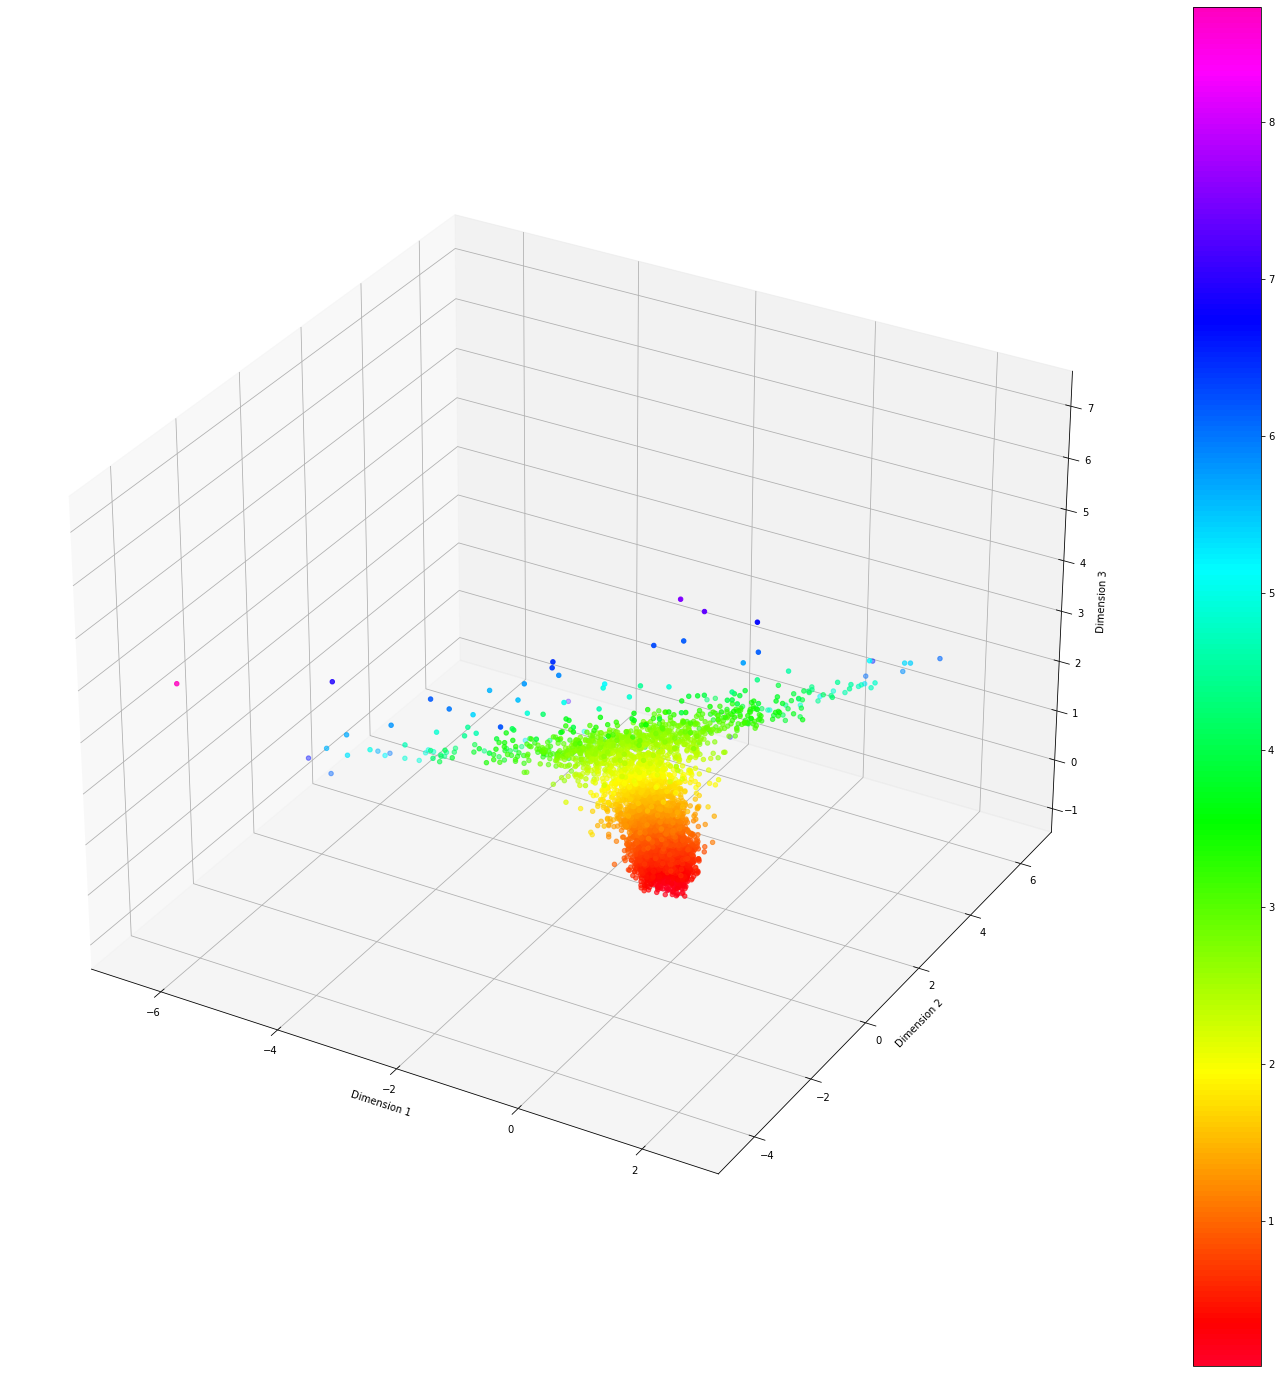

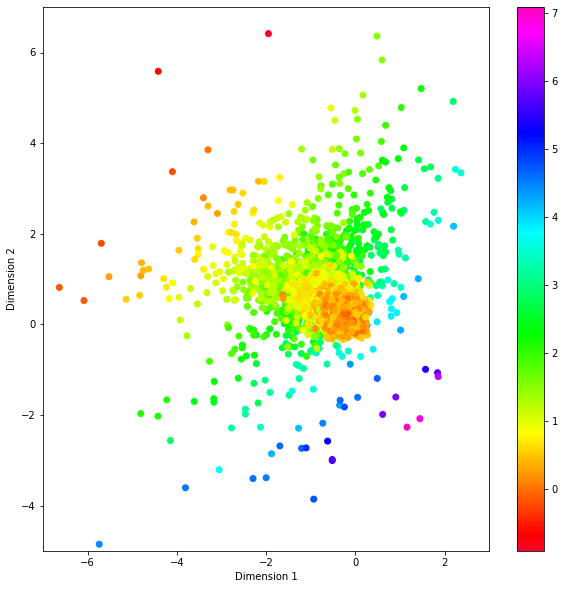

In [81]:
show_words(vocab, words=False)

In [82]:
# # Randomly choose 10 words
# indices = np.random.choice(range(num_words), 10)

['guitar', 'piano', 'string', 'violin', 'viola', 'cello', 'drum', 'flute', 'trumpet']


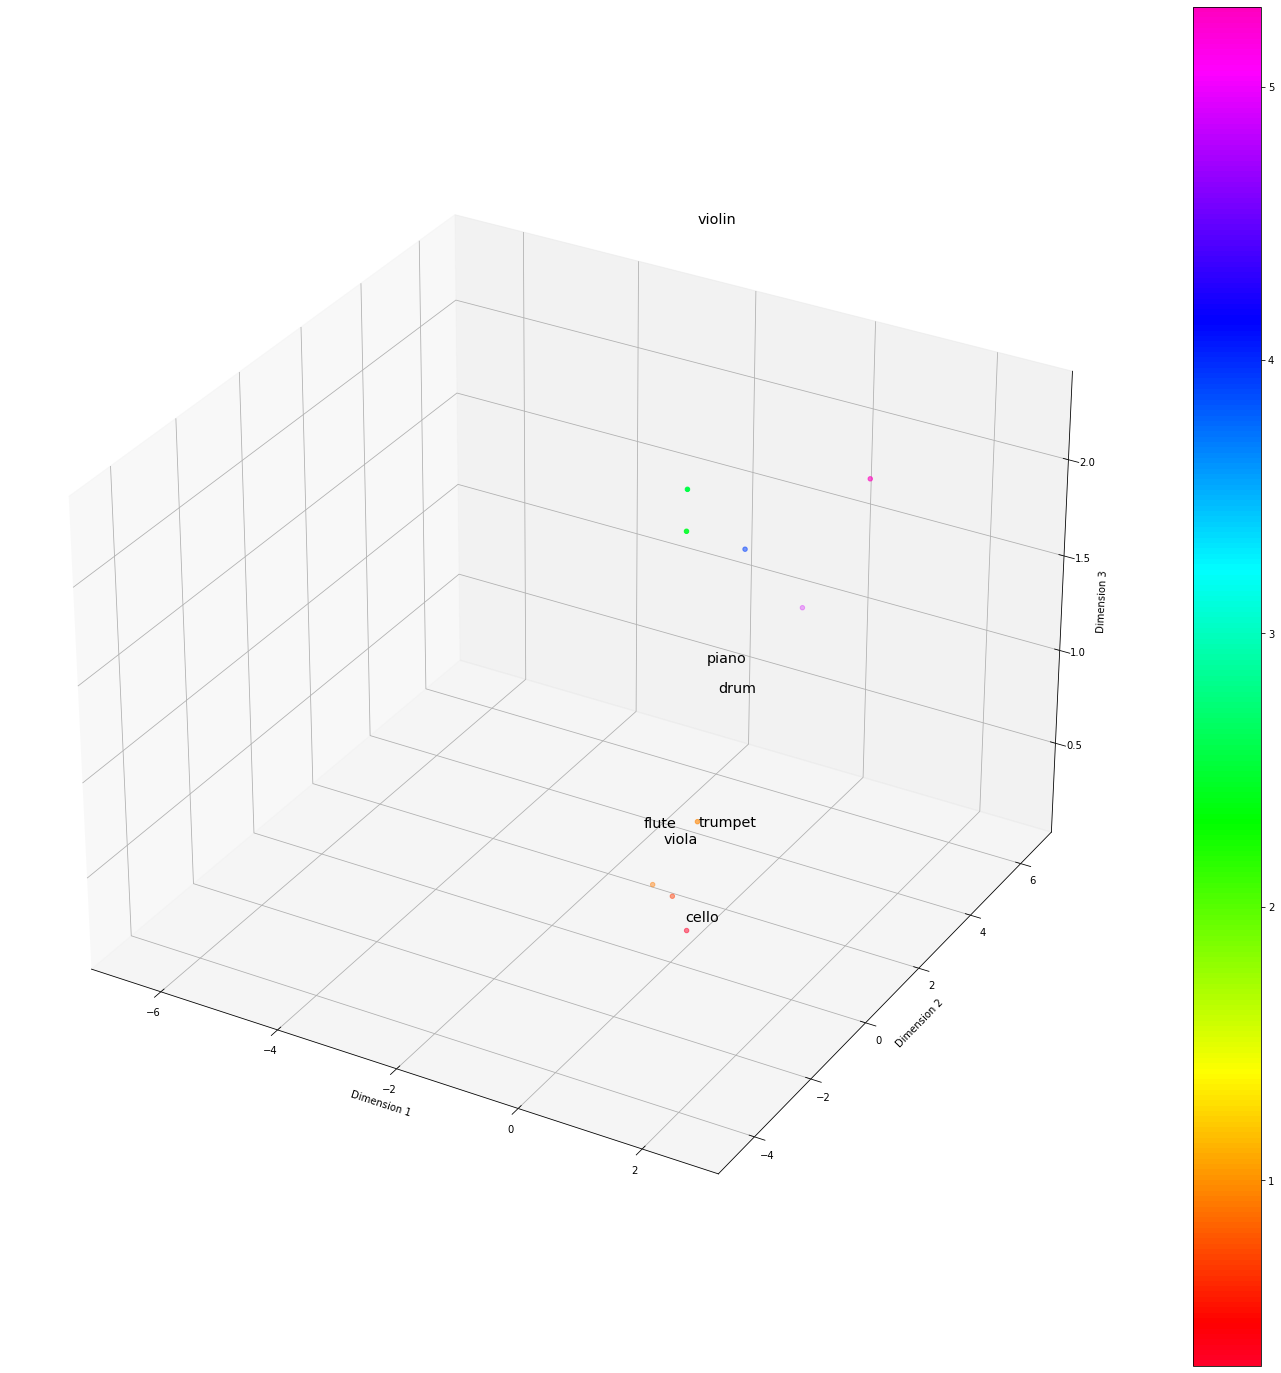

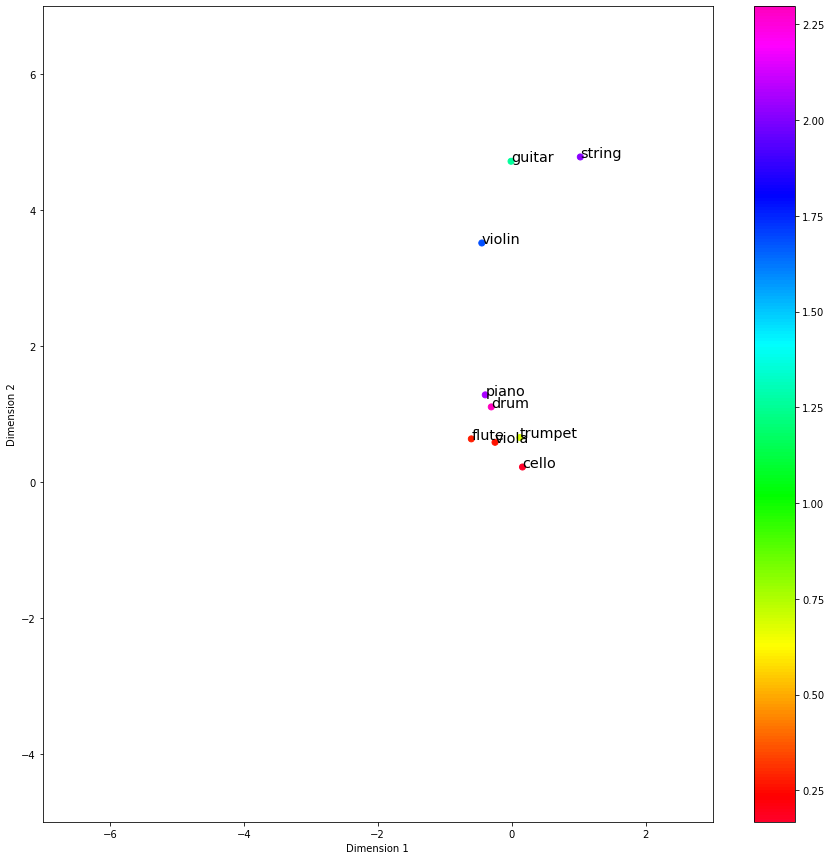

In [83]:
show_words(['guitar', 'piano', 'string', 'violin', 'viola', 'cello', 'drum', 'flute', 'trumpet'], size_2d=(15, 15))

-1
['good', 'great', 'nice', 'well', 'excellent', 'love', 'perfect', 'comfortable', 'durable', 'smooth', 'remarkable', 'terrible', 'horrible', 'flimsy', 'inferior', 'uncomfortable', 'difficult', 'waste', 'suck', 'clunky', 'unusable', 'dead', 'unnecessary']


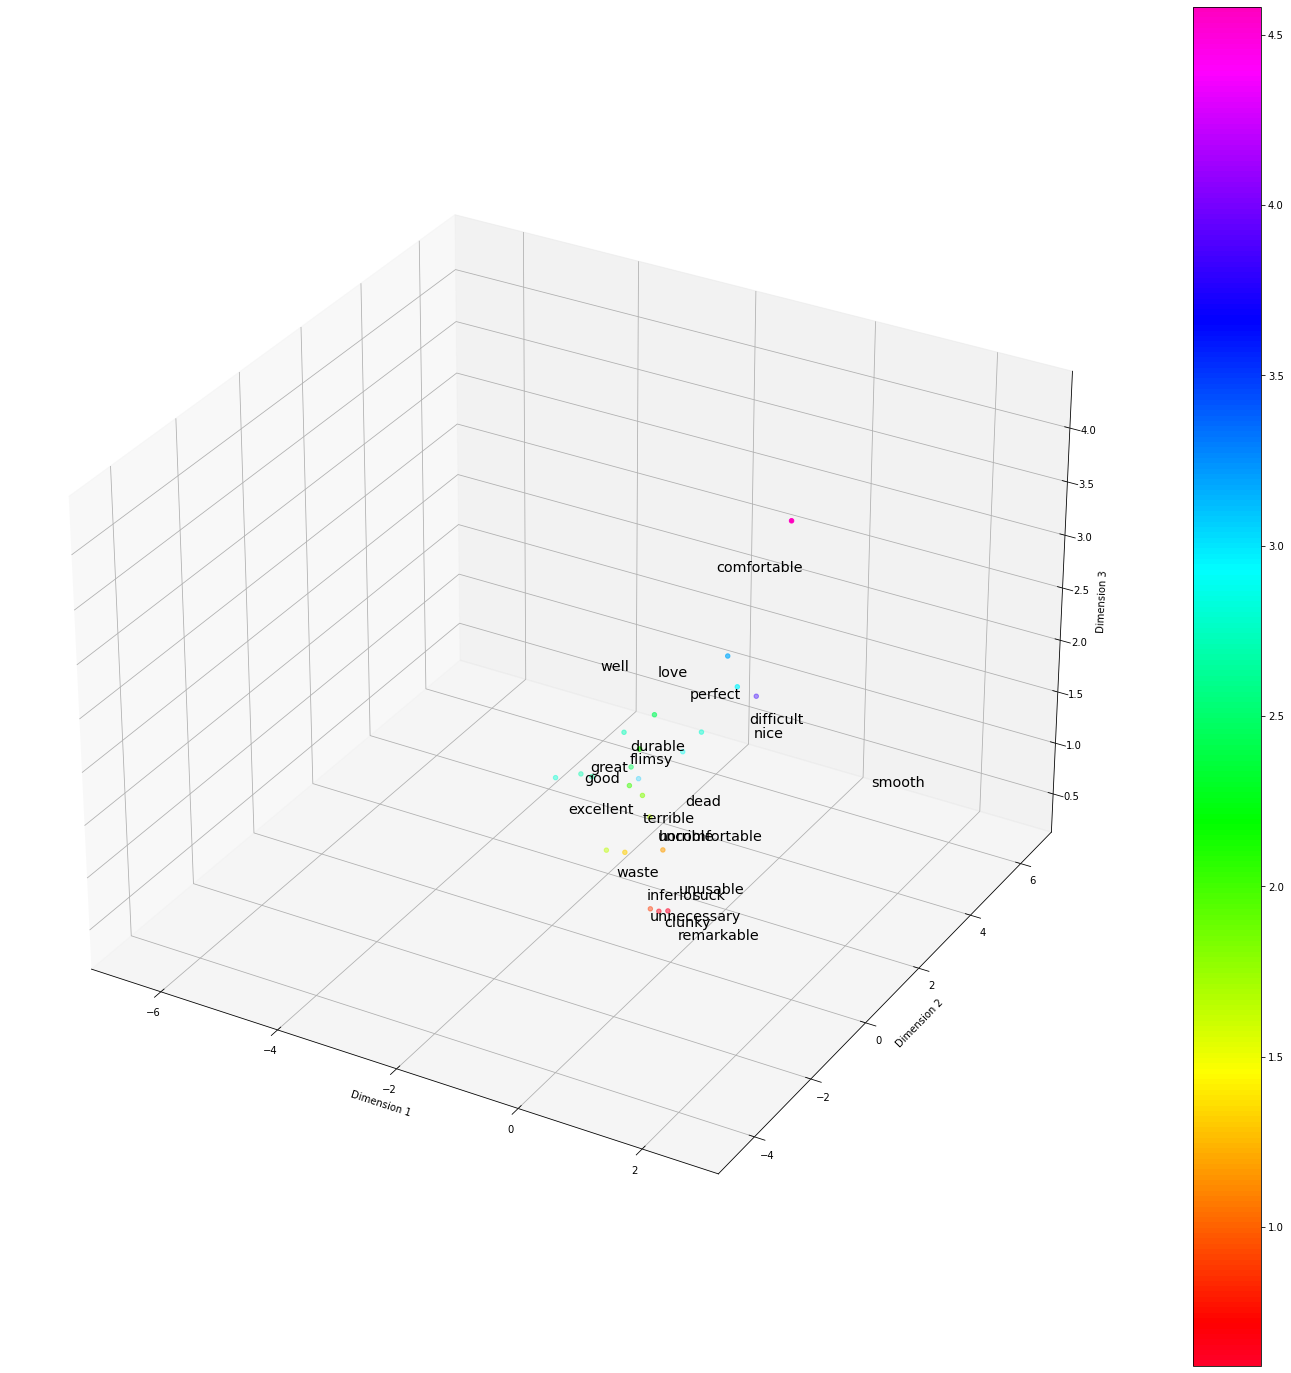

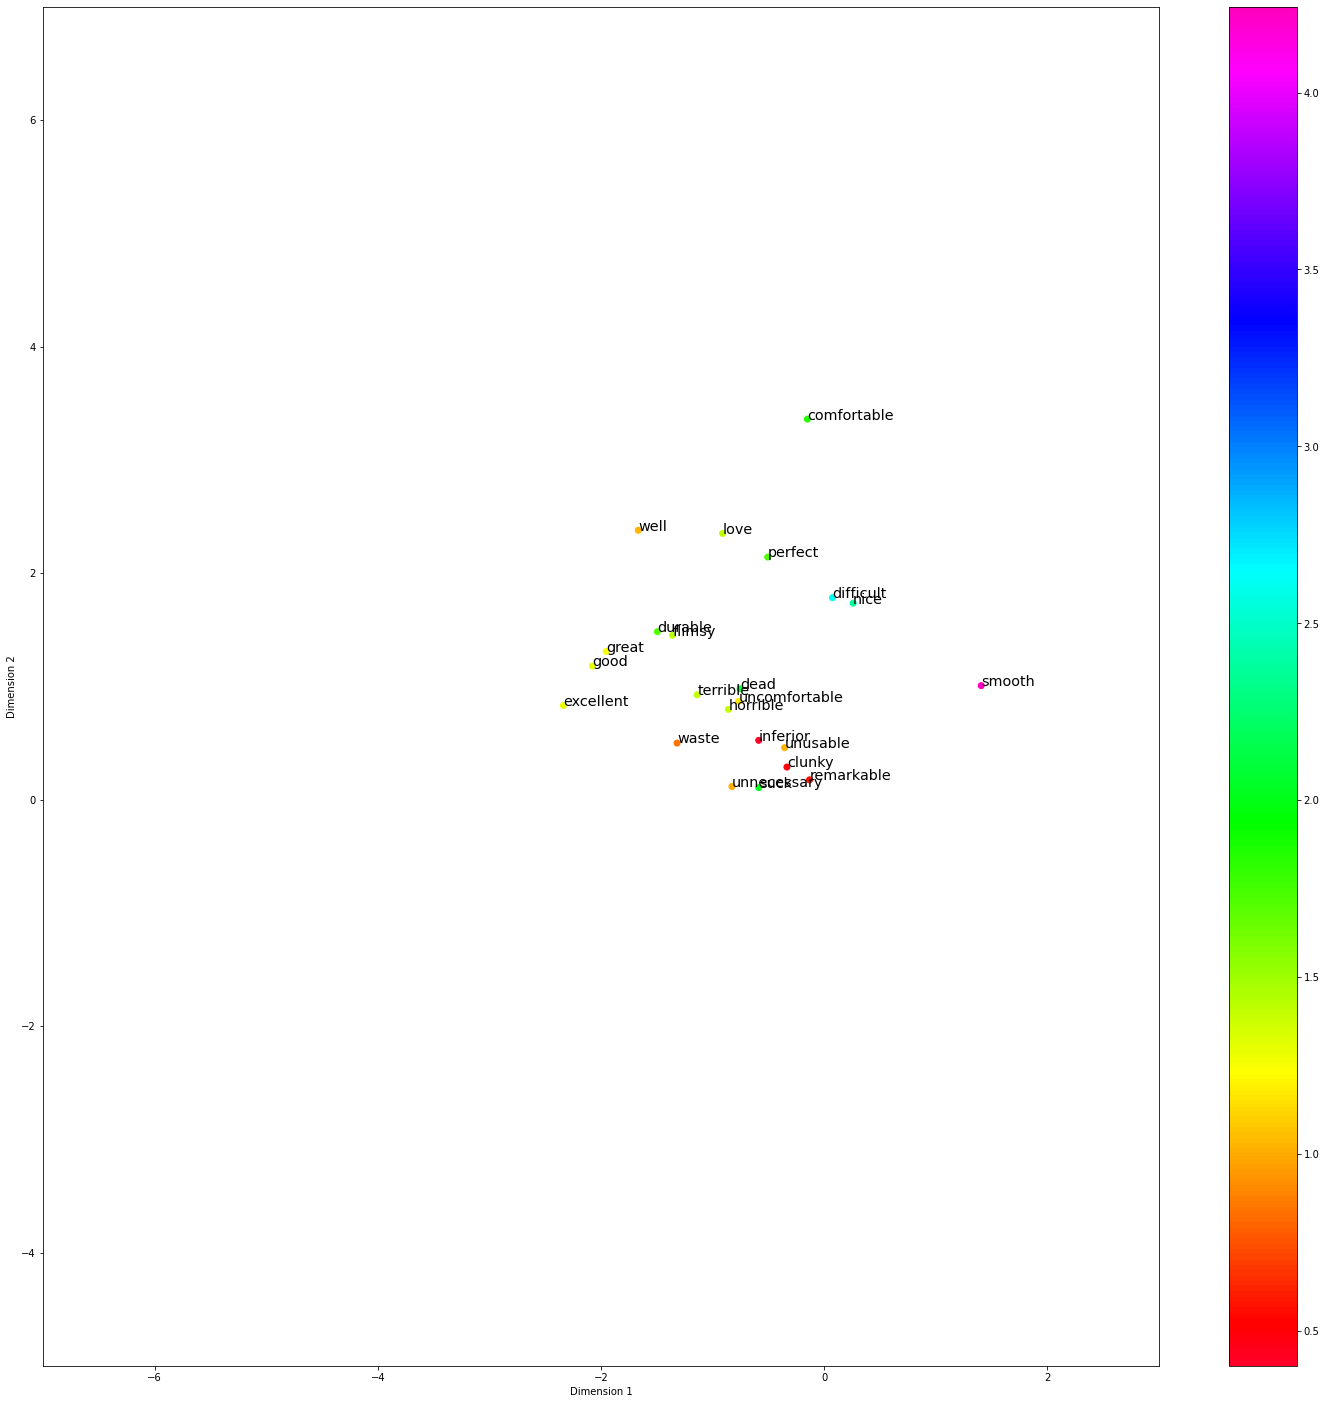

In [84]:
pos_words = ['good', 'great', 'nice', 'well', 'excellent', 'love',
             'perfect', 'comfortable', 'durable', 'smooth', 'remarkable']
neg_words = ['terrible', 'horrible', 'flimsy', 'inferior', 'uncomfortable', 'difficult',
             'waste', 'suck', 'clunky', 'unusable', 'dead', 'unnecessary']
print(len(pos_words) - len(neg_words))
show_words(pos_words + neg_words, size_2d=(25, 25))

In [85]:
# Most common words
str(model.wv.index_to_key[:200])

"['guitar', 'string', 'sound', 'great', 'like', 'good', 'pedal', 'well', 'work', 'would', 'price', 'pick', 'really', 'little', 'much', 'time', 'quality', 'tone', 'also', 'used', 'make', 'cable', 'nice', 'better', 'tuner', 'stand', 'strap', 'need', 'thing', 'easy', 'using', 'play', 'bought', 'product', 'even', 'year', 'playing', 'look', 'want', 'acoustic', 'made', 'still', 'case', 'love', 'right', 'feel', 'instrument', 'back', 'bass', 'first', 'best', 'problem', 'could', 'come', 'fender', 'enough', 'small', 'around', 'recommend', 'without', 'long', 'think', 'give', 'hold', 'effect', 'tune', 'cheap', 'last', 'keep', 'light', 'another', 'know', 'capo', 'take', 'high', 'different', 'pretty', 'power', 'find', 'review', 'many', 'perfect', 'fine', 'electric', 'looking', 'sure', 'microphone', 'something', 'never', 'though', 'recording', 'clean', 'volume', 'always', 'since', 'tube', 'metal', 'tried', 'hard', 'going', 'battery', 'neck', 'found', 'solid', 'tuning', 'seems', 'music', 'noise', 'mon

['guitar', 'piano', 'string', 'pedal', 'tuner', 'pick', 'acoustic', 'cable', 'tuner', 'instrument', 'capo', 'bass', 'speaker', 'board', 'metal', 'microphone', 'knob', 'tube', 'volume', 'unit', 'switch', 'plastic', 'electric', 'music', 'line', 'plug', 'power', 'finger', 'screw', 'studio', 'behringer', 'battery', 'control', 'note', 'player', 'practice']


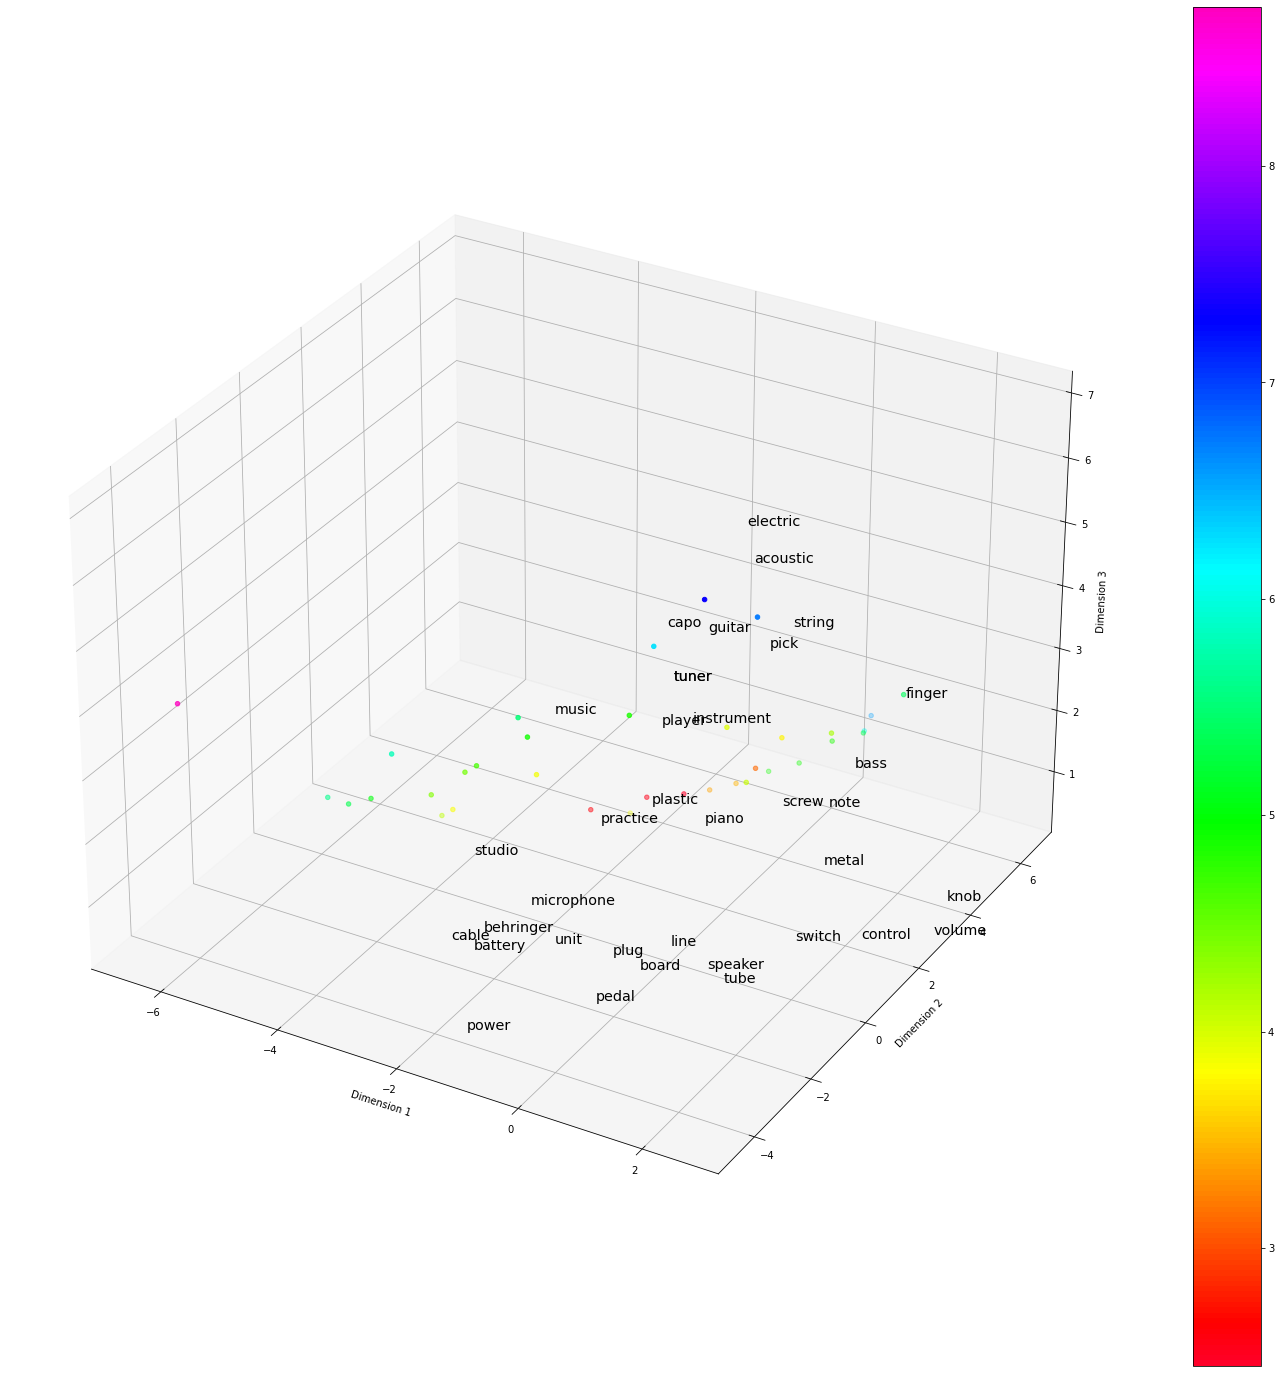

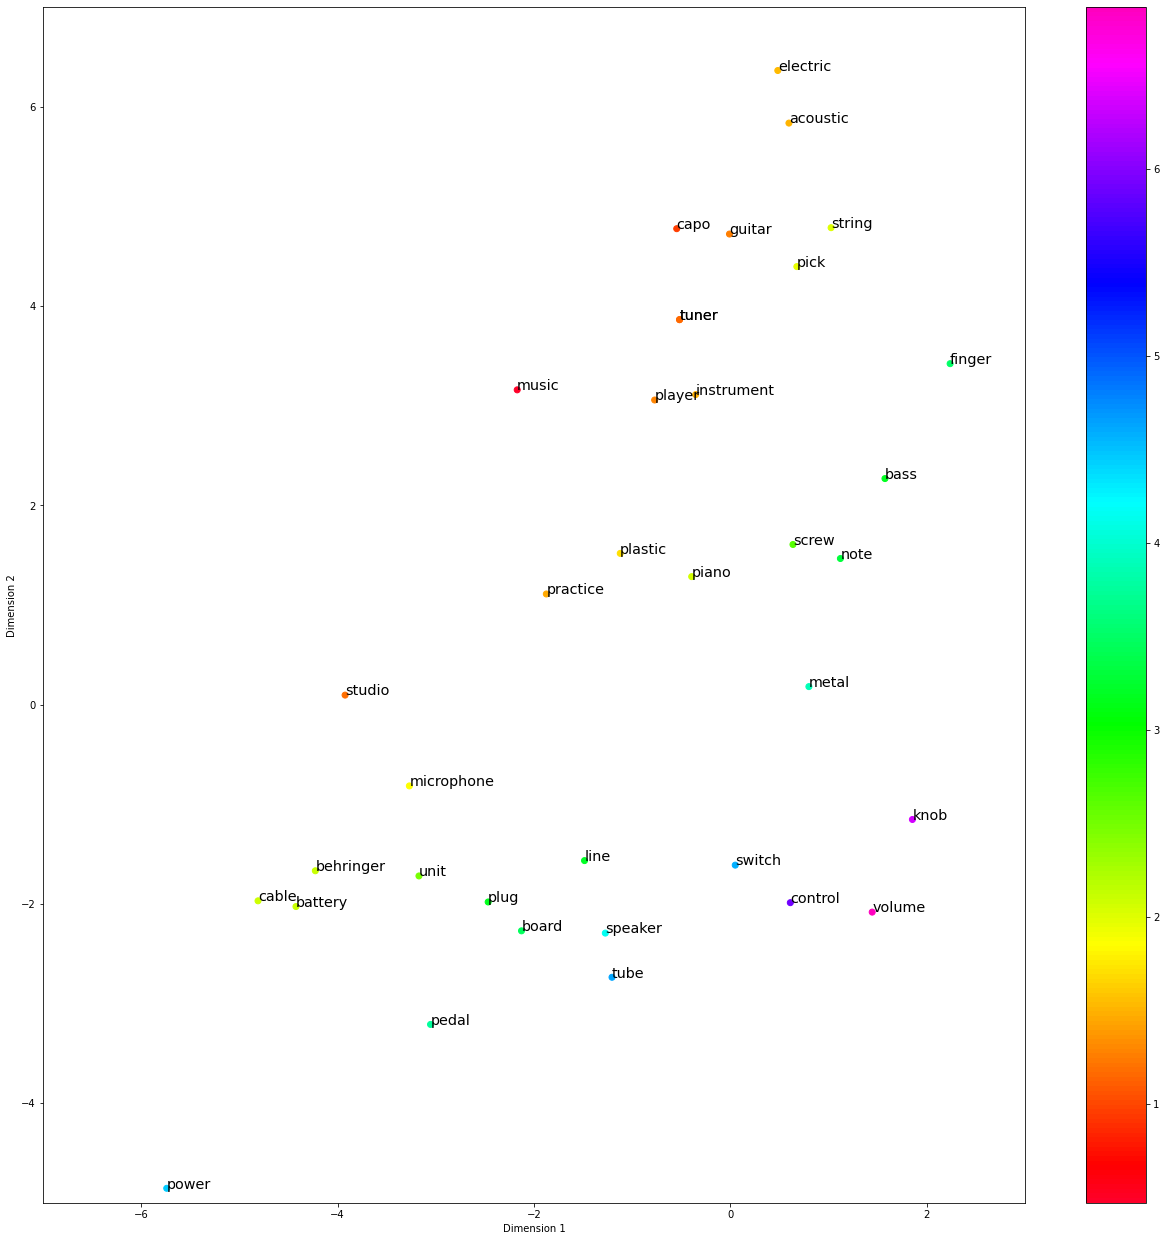

In [86]:
show_words(['guitar', 'piano', 'string', 'pedal', 'tuner', 'pick', 'acoustic', 'cable', 'tuner',
            'instrument', 'capo', 'bass', 'speaker', 'board', 'metal', 'microphone', 'knob', 'tube',
            'volume', 'unit', 'switch', 'plastic', 'electric', 'music', 'line', 'plug', 'power',
            'finger', 'screw', 'studio', 'behringer', 'battery', 'control', 'note', 'player', 'practice'], size_2d=(22, 22))

['guitar', 'string', 'sound', 'great', 'like', 'good', 'pedal', 'well', 'work', 'would', 'price', 'pick', 'really', 'little', 'much', 'time', 'quality', 'tone', 'also', 'used', 'make', 'cable', 'nice', 'better', 'tuner', 'stand', 'strap', 'need', 'thing', 'easy', 'using', 'play', 'bought', 'product', 'even', 'year', 'playing', 'look', 'want', 'acoustic', 'made', 'still', 'case', 'love', 'right', 'feel', 'instrument', 'back', 'bass', 'first', 'best', 'problem', 'could', 'come', 'fender', 'enough', 'small', 'around', 'recommend', 'without', 'long', 'think', 'give', 'hold', 'effect', 'tune', 'cheap', 'last', 'keep', 'light', 'another', 'know', 'capo', 'take', 'high', 'different', 'pretty', 'power', 'find', 'review', 'many', 'perfect', 'fine', 'electric', 'looking', 'sure', 'microphone', 'something', 'never', 'though', 'recording', 'clean', 'volume', 'always', 'since', 'tube', 'metal', 'tried', 'hard', 'going', 'battery', 'neck', 'found', 'solid', 'tuning', 'seems', 'music', 'noise', 'mone

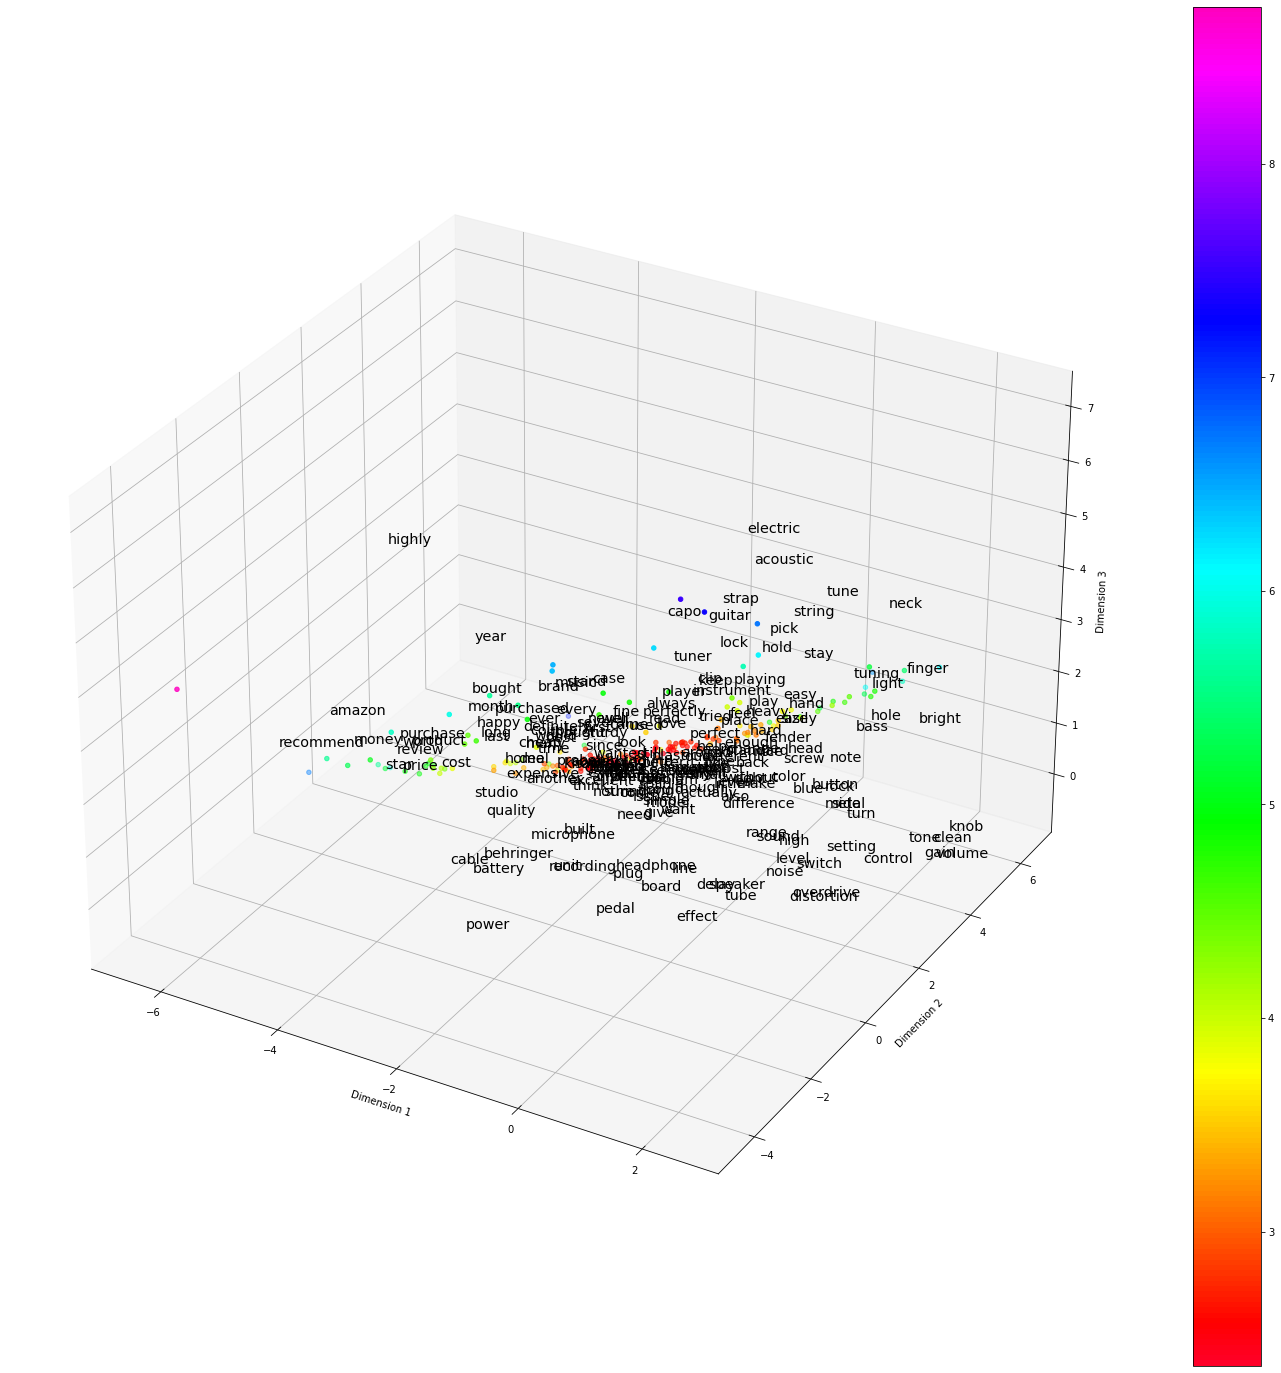

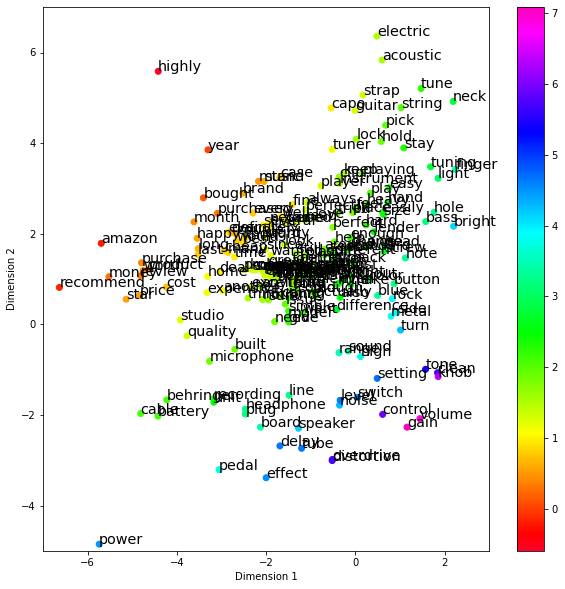

In [87]:
show_words(model.wv.index_to_key[:200])

In [88]:
# from functools import reduce

# def sum_sentence(sentence):
#     try:
#         def add_lists(xs, ys):
#             return map(lambda xy: xy[0] + xy[1], zip(xs, ys))
#         return list(reduce(add_lists, sentence, [0.0] * 100))
#     except:
#         print(sentence)
#         raise sentence
# sent_sums = review_df['Tokens'].apply(sum_sentence) #lambda sentence: reduce(lambda a, b: a + b, sentence, [0] * 100))

In [89]:
# sent_sums